<a href="https://colab.research.google.com/github/kashishthakur26/Computer-vision-learning/blob/main/deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

## Loading the pre-built convolution NN

In [2]:
base_model = tf.keras.applications.InceptionV3(include_top=False , weights = 'imagenet')


87910968/87910968 [==============================] - 5s 0us/step


In [3]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [4]:
len(base_model.layers)

311

In [5]:
names = ['mixed3','mixed5']

In [6]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [7]:
layers = [base_model.get_layer(name).output for name in names]

In [8]:
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [9]:
deep_dream_model = tf.keras.Model(inputs = base_model.input , outputs = layers)

## Loading and the preprocessing the images

In [10]:
import zipfile
zipfile = zipfile.ZipFile('/content/drive/MyDrive/Colab-notebooks/Images-20230705T053212Z-001.zip','r')
zipfile.extractall()
zipfile.close()

In [11]:
image = tf.keras.preprocessing.image.load_img('/content/Images/StaryNight.jpg',
                                              target_size = (225 , 375))

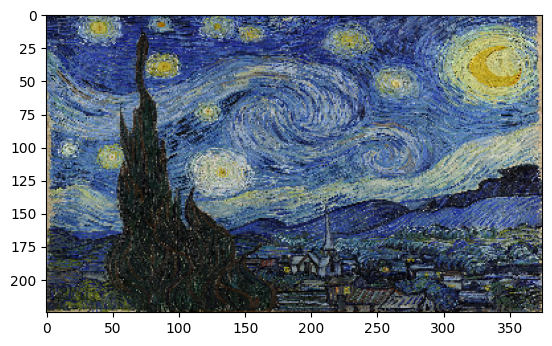

In [12]:
plt.imshow(image)

In [13]:
image = tf.keras.preprocessing.image.img_to_array(image)

In [14]:
image = tf.keras.applications.inception_v3.preprocess_input(image)

## Getting the activations

In [15]:
image_batch = tf.expand_dims(image , axis=0)

In [16]:
activations = deep_dream_model.predict(image_batch)

1/1 [==============================] - 11s 11s/step


## Calculating the loss

In [17]:
def calculate_loss(image , network):
  image_batch = tf.expand_dims(image , axis=0)
  activations = network(image_batch)

  losses = []
  for act in activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

In [18]:
import numpy as np

In [19]:
calculate_loss(image, deep_dream_model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6168046>

## Gradient ascent

In [20]:
@tf.function
def deep_dream(network, image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = calculate_loss(image, network)

  gradients = tape.gradient(loss, image)
  gradients /= tf.math.reduce_std(gradients)
  image = image + gradients * learning_rate
  image = tf.clip_by_value(image, -1, 1)

  return loss, image

In [21]:
def inverse_transform(image):
  image = 255 * (image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)

In [22]:
def run_deep_dream(network, image, epochs, learning_rate):
  for epoch in range(epochs):
    loss, image = deep_dream(network, image, learning_rate)

    if epoch % 200 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(inverse_transform(image))
      plt.show()
      print('Epoch {}, loss {}'.format(epoch, loss))

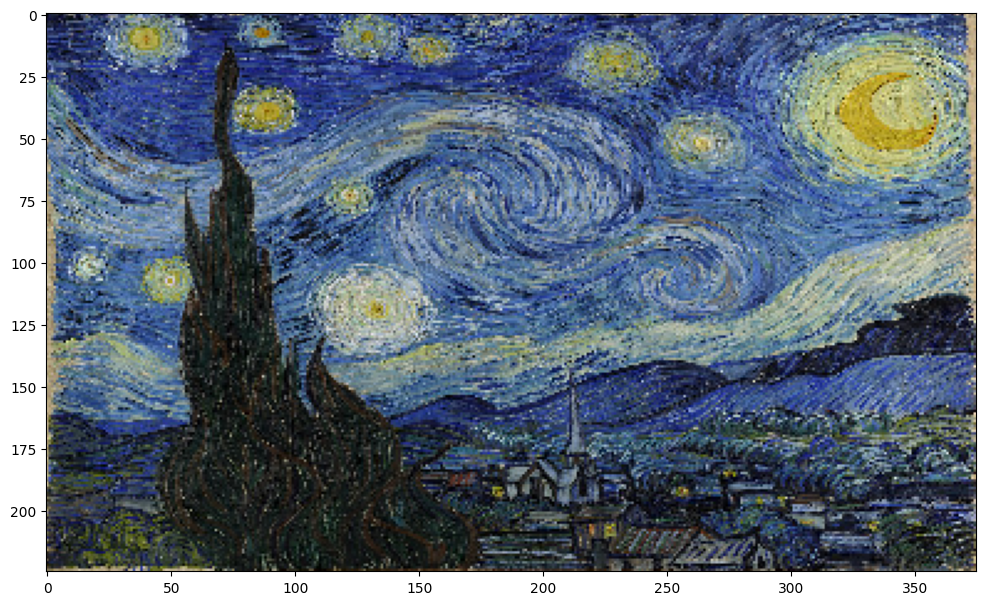

Epoch 0, loss 0.6168045401573181


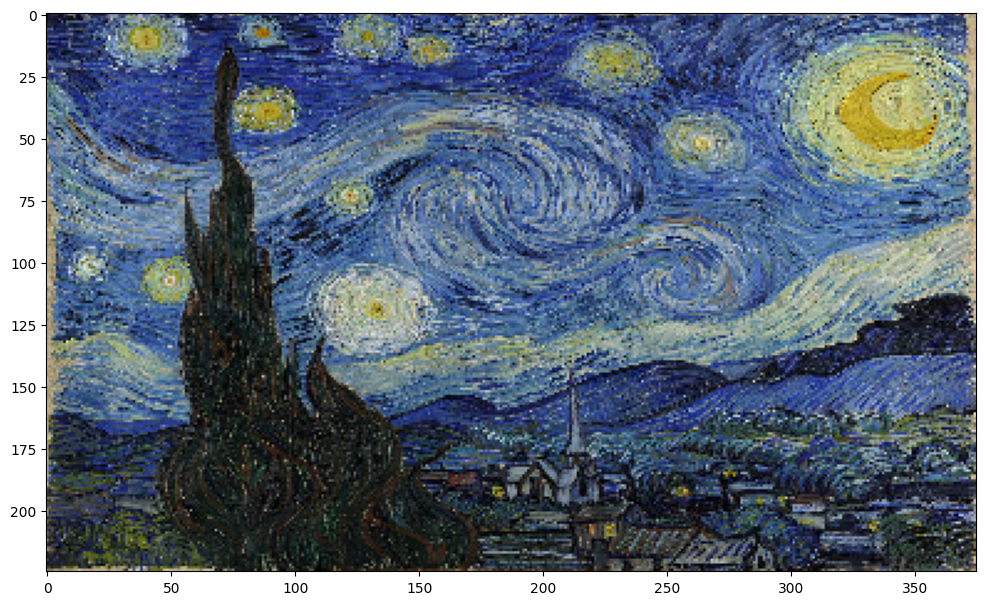

Epoch 200, loss 0.8620572090148926


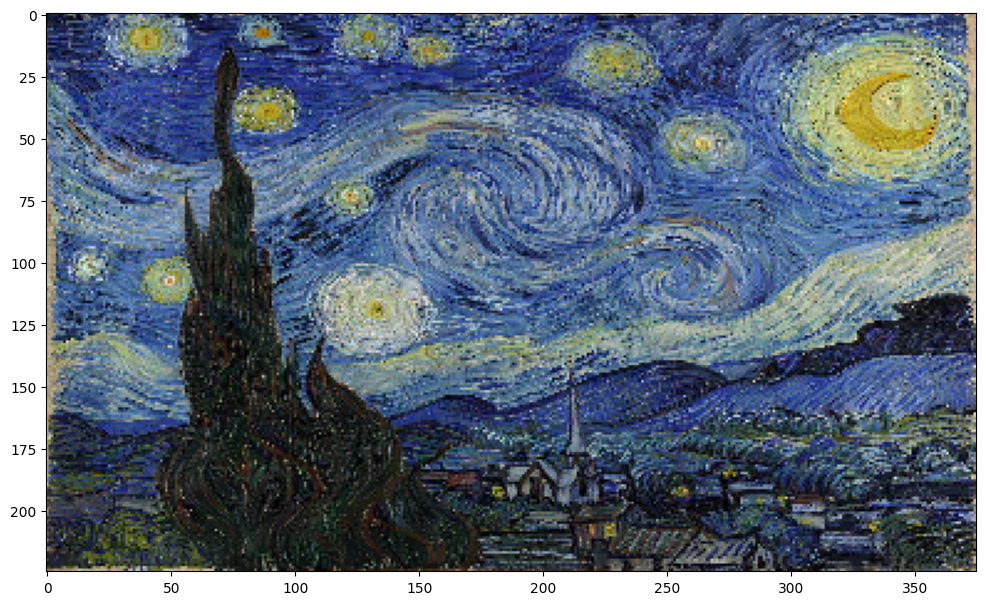

Epoch 400, loss 1.0593955516815186


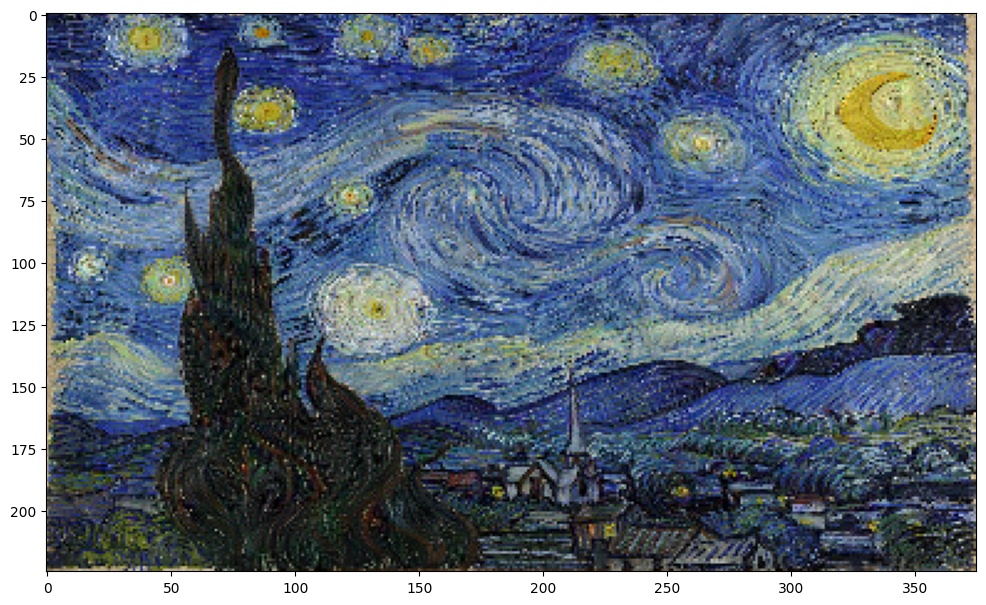

Epoch 600, loss 1.2157740592956543


In [ ]:
run_deep_dream(network=deep_dream_model, image=image, epochs = 8000, learning_rate=0.0001)
